In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import pandas as pd
import shapely.wkt as wkt
from shapely.geometry import Point

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [3]:
### Pull all cand ras+decs:
query = ("SELECT c.ra, c.dec FROM candidates c "
         "JOIN objects o ON o.candidate_id=c.id "
         "JOIN subtractions s ON s.id=o.subtraction_id "
         "JOIN exposures e ON e.id = s.exposure_id "
         "WHERE (e.proposalid = '2021A-0113' "
         "OR e.proposalid = '2021B-0149' )"
         "AND c.dec > 0 "
         "LIMIT 10000000")
cursor.execute( query, )

radecquery = np.array(cursor.fetchall()).transpose().astype(float)
radecquery = np.unique(radecquery.transpose(), axis=0).transpose()

In [4]:
### Create a polygon object using all of those points as vertices
polystr = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery.T,2)]).replace("'","")
pol = wkt.loads("""
POLYGON
(({}))
""".format(polystr[1:-1]+', '+polystr[1:12]))

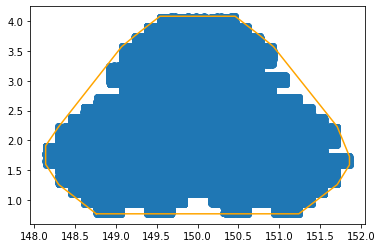

In [5]:
### Simplify the polygon to the simplest convex shape that encloses all data:
polconvhull = pol.convex_hull
convhullarr = polconvhull.exterior.coords.xy

plt.scatter(*radecquery)
plt.plot(convhullarr[0],convhullarr[1],color='orange') # orange is simplest convex polygon enclosing all pts

In [6]:
### Grap every AGN within that orange boundary from SIMBAD at http://simbad.u-strasbg.fr/simbad/sim-tap
### Use this query, save as result.txt in this directory
print("SELECT distinct main_id, ra, dec, otype_txt")
print("FROM basic")
print("WHERE otype = 'AGN..'") # 'AGN..' here means all subtypes of AGN (QSOs, seyferts, etc.)
print("AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1".format(str(list(np.array(convhullarr).T.flatten()))[1:-1]))
print("GROUP BY main_id, otype_txt, ra, dec")

### SIMBAD ADQL queries for two biggest catalogs for AGN in this field, the POLYGON numbers aren't excluding any of their data
### Alternatively, you can use the files COSMOS2015_result.txt or ACS-GC_result.txt in the next cell
# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'COSMOS2015%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.76, 0.77, 148.3, 1.26, 148.14, 1.6, 148.14, 1.91, 148.3, 2.23, 149.07, 3.57, 149.23, 3.75, 149.38, 3.91, 149.54, 4.08, 150.46, 4.08, 150.62, 3.91, 150.77, 3.75, 150.93, 3.57, 151.71, 2.23, 151.86, 1.73, 151.86, 1.59, 151.71, 1.26, 151.24, 0.77, 148.76, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'ACS-GC%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.76, 0.77, 148.3, 1.26, 148.14, 1.6, 148.14, 1.91, 148.3, 2.23, 149.07, 3.57, 149.23, 3.75, 149.38, 3.91, 149.54, 4.08, 150.46, 4.08, 150.62, 3.91, 150.77, 3.75, 150.93, 3.57, 151.71, 2.23, 151.86, 1.73, 151.86, 1.59, 151.71, 1.26, 151.24, 0.77, 148.76, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """;

SELECT distinct main_id, ra, dec, otype_txt
FROM basic
WHERE otype = 'AGN..'
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 148.76, 0.77, 148.3, 1.26, 148.14, 1.6, 148.14, 1.91, 148.3, 2.23, 149.07, 3.57, 149.23, 3.75, 149.38, 3.91, 149.54, 4.08, 150.46, 4.08, 150.62, 3.91, 150.77, 3.75, 150.93, 3.57, 151.71, 2.23, 151.86, 1.73, 151.86, 1.59, 151.71, 1.26, 151.24, 0.77, 148.76, 0.77)) = 1
GROUP BY main_id, otype_txt, ra, dec


In [91]:
agn = np.loadtxt('./COSMOS_result.txt', skiprows=2,delimiter='|', dtype=str) # All catalogs
# agns = np.loadtxt('./ACS-GC_result.txt', skiprows=2,delimiter='|', dtype=str) # ACS-GC catalog only
# agns = np.loadtxt('./COSMOS2015_result.txt', skiprows=2,delimiter='|', dtype=str) # COSMOS2015 catalog only

agnnames, agnras, agndecs, agntypes = agn.T
agnras, agndecs = agnras.astype(float), agndecs.astype(float)
agncoords = np.array([agnras,agndecs]).T

In [92]:
### Now have coords for every agn in the orange boundary (this includes things outside our fields still)
agncoords

array([[148.64301056,   2.59270066],
       [149.59890909,   1.2099168 ],
       [149.661917  ,   2.39674   ],
       ...,
       [150.64840833,   1.817525  ],
       [150.57816667,   1.97094444],
       [149.70599583,   2.419475  ]])

#### This section needs to be less generous, but is close to correct

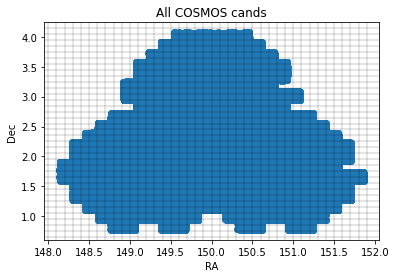

In [93]:
### Create a stricter boundary now that we have the raw data:
### I do this by making a grid and labelling each rectangle as 'containing data' or not 
### (if I don't condense the data like this, it's computationally prohibitive)

plt.scatter(radecquery[0],radecquery[1])
plt.title("All COSMOS cands")
plt.xlabel("RA")
plt.ylabel("Dec")
prec=0.1
ys = np.arange(0.65,4.25,prec)
xs = np.arange(148,152,prec)
xys = np.meshgrid(xs,ys)

for i in ys:
    plt.axhline(i, color='black',lw=0.2)
for i in xs:
    plt.axvline(i, color='black',lw=0.2)

In [94]:
good = []
for i in range(len(xs)):
    for j in range(len(ys)):
        data = radecquery[0][np.where((radecquery[0]<xs[i]+prec) & (radecquery[0]>xs[i]) \
                                      & (radecquery[1]<ys[j]+prec) & (radecquery[1]>ys[j]))[0]]
        if len(data) > 0:
            good.append([i,j])
goodidx = np.array(good).transpose()
goodxs = xs[goodidx[0]] + prec/2
goodys = ys[goodidx[1]] + prec/2
goods = np.array([goodxs,goodys])

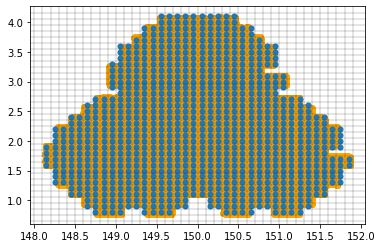

In [95]:
plt.scatter(*radecquery,color='orange')
plt.scatter(*goods,lw=0.05)
for i in ys:
    plt.axhline(i, color='black',lw=0.2)
for i in xs:
    plt.axvline(i, color='black',lw=0.2)

In [96]:
pol2str = str([str(i[0])+" "+str(i[1]) for i in np.round(goods.T,2)]).replace("'","")
pol2 = wkt.loads("""
POLYGON
(({}))
""".format(pol2str[1:-1]+', '+pol2str[1:11]))
pol3 = pol2.buffer(0.1)
pol3arr = pol3.exterior.coords.xy

In [97]:
agnmsk = []
for coord in agncoords:
    pt = Point(coord[0],coord[1])
    agnmsk.append(pt.within(pol3))
agncoords1 = agncoords[agnmsk]
agnnames1 = agnnames[agnmsk]
agntypes1 = agntypes[agnmsk]

In [98]:
len(agncoords), len(agncoords1)

(3944, 3926)

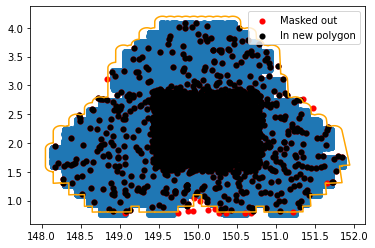

In [99]:
plt.scatter(*radecquery)
plt.scatter(*agncoords.T,color='red', lw=0.1, label="Masked out")
plt.plot(*pol3arr, color='orange')
plt.scatter(*agncoords1.T,color='black', lw=0.1, label="In new polygon")
plt.legend(loc='upper right')

#### So now we have all of the known QSOs we could theoretically detect in COSMOS
Next step is to match them up to "probably-real" candidates

In [100]:
### Grab all cand names for 'probably-real' cands
realcandsarr = np.genfromtxt('../candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat', dtype=str)
realcands = np.unique(realcandsarr.T[1])

In [101]:
### Find coords and make SkyCoord objects for all candidates:
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query,(i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i,res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0],i[1][1], unit='deg')] for i in candcoord])

In [102]:
### Make a catalog-style set of SkyCoords for the SIMBAD sample
agncoords2 = SkyCoord(agncoords1,unit='deg')

In [103]:
### Match the datasets with a 2 arcsec radius
matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(agncoords2)
    if sep2d < 2*u.arcsec:
        matches.append([i,coord,idx, sep2d])
matches = np.array(matches)

/tmp/ipykernel_43417/2178453017.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matches = np.array(matches)


In [104]:
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(matches), len(agncoords1)))
print("This represents {} percent of the known agn in our field".format(len(matches)/len(agncoords1)*100))


We detected 295 known agn as 'probably-real' candidates, out of 3926 known agn
This represents 7.5140091696383084 percent of the known agn in our field


In [105]:
matchmsk = matches.T[2].astype(int)
agncoordsmatched = agncoords1[matchmsk]
agntypesmatched = agntypes1[matchmsk]
agnnamesmatched = agnnames1[matchmsk]
print("For the ACS-GC sample:")
for typee in np.unique(agntypesmatched):
    msk = np.where(agntypesmatched==typee)[0]
    nummatched = len(agnnamesmatched[msk])
    numtot = len(agnnames1[agntypes1==typee])
    perc = np.round(nummatched/numtot*100,2)
    print("found {} out of {} {} ({} %)".format(nummatched, numtot,typee,perc))

For the ACS-GC sample:
found 89 out of 3214 "AGN"     (2.77 %)
found 191 out of 595 "QSO"     (32.1 %)
found 14 out of 58 "Sy1"     (24.14 %)
found 1 out of 24 "Sy2"     (4.17 %)
